In [112]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
import glob
import pandas as pd
import json

plt.style.use('seaborn-white')
mpl.rcParams.update({'font.size': 16})

## Investigating the effect of S/N on Measurement Difference and Lowercut

In [41]:
# Make dictionary of cluster S/N tables

cluster_snr = glob.glob("data/ew_known/equiv_widths/*snr.txt")
snr_dict = {}
for cluster in cluster_snr:
    df = pd.read_csv(cluster, delim_whitespace = True)
    key = cluster.split("/")[-1].split("_")[0]
    snr_dict[key] = df

### Measurement Difference

[-0.022579113355360426, 3.4697321569161494]
R-Squared:  0.172047898913


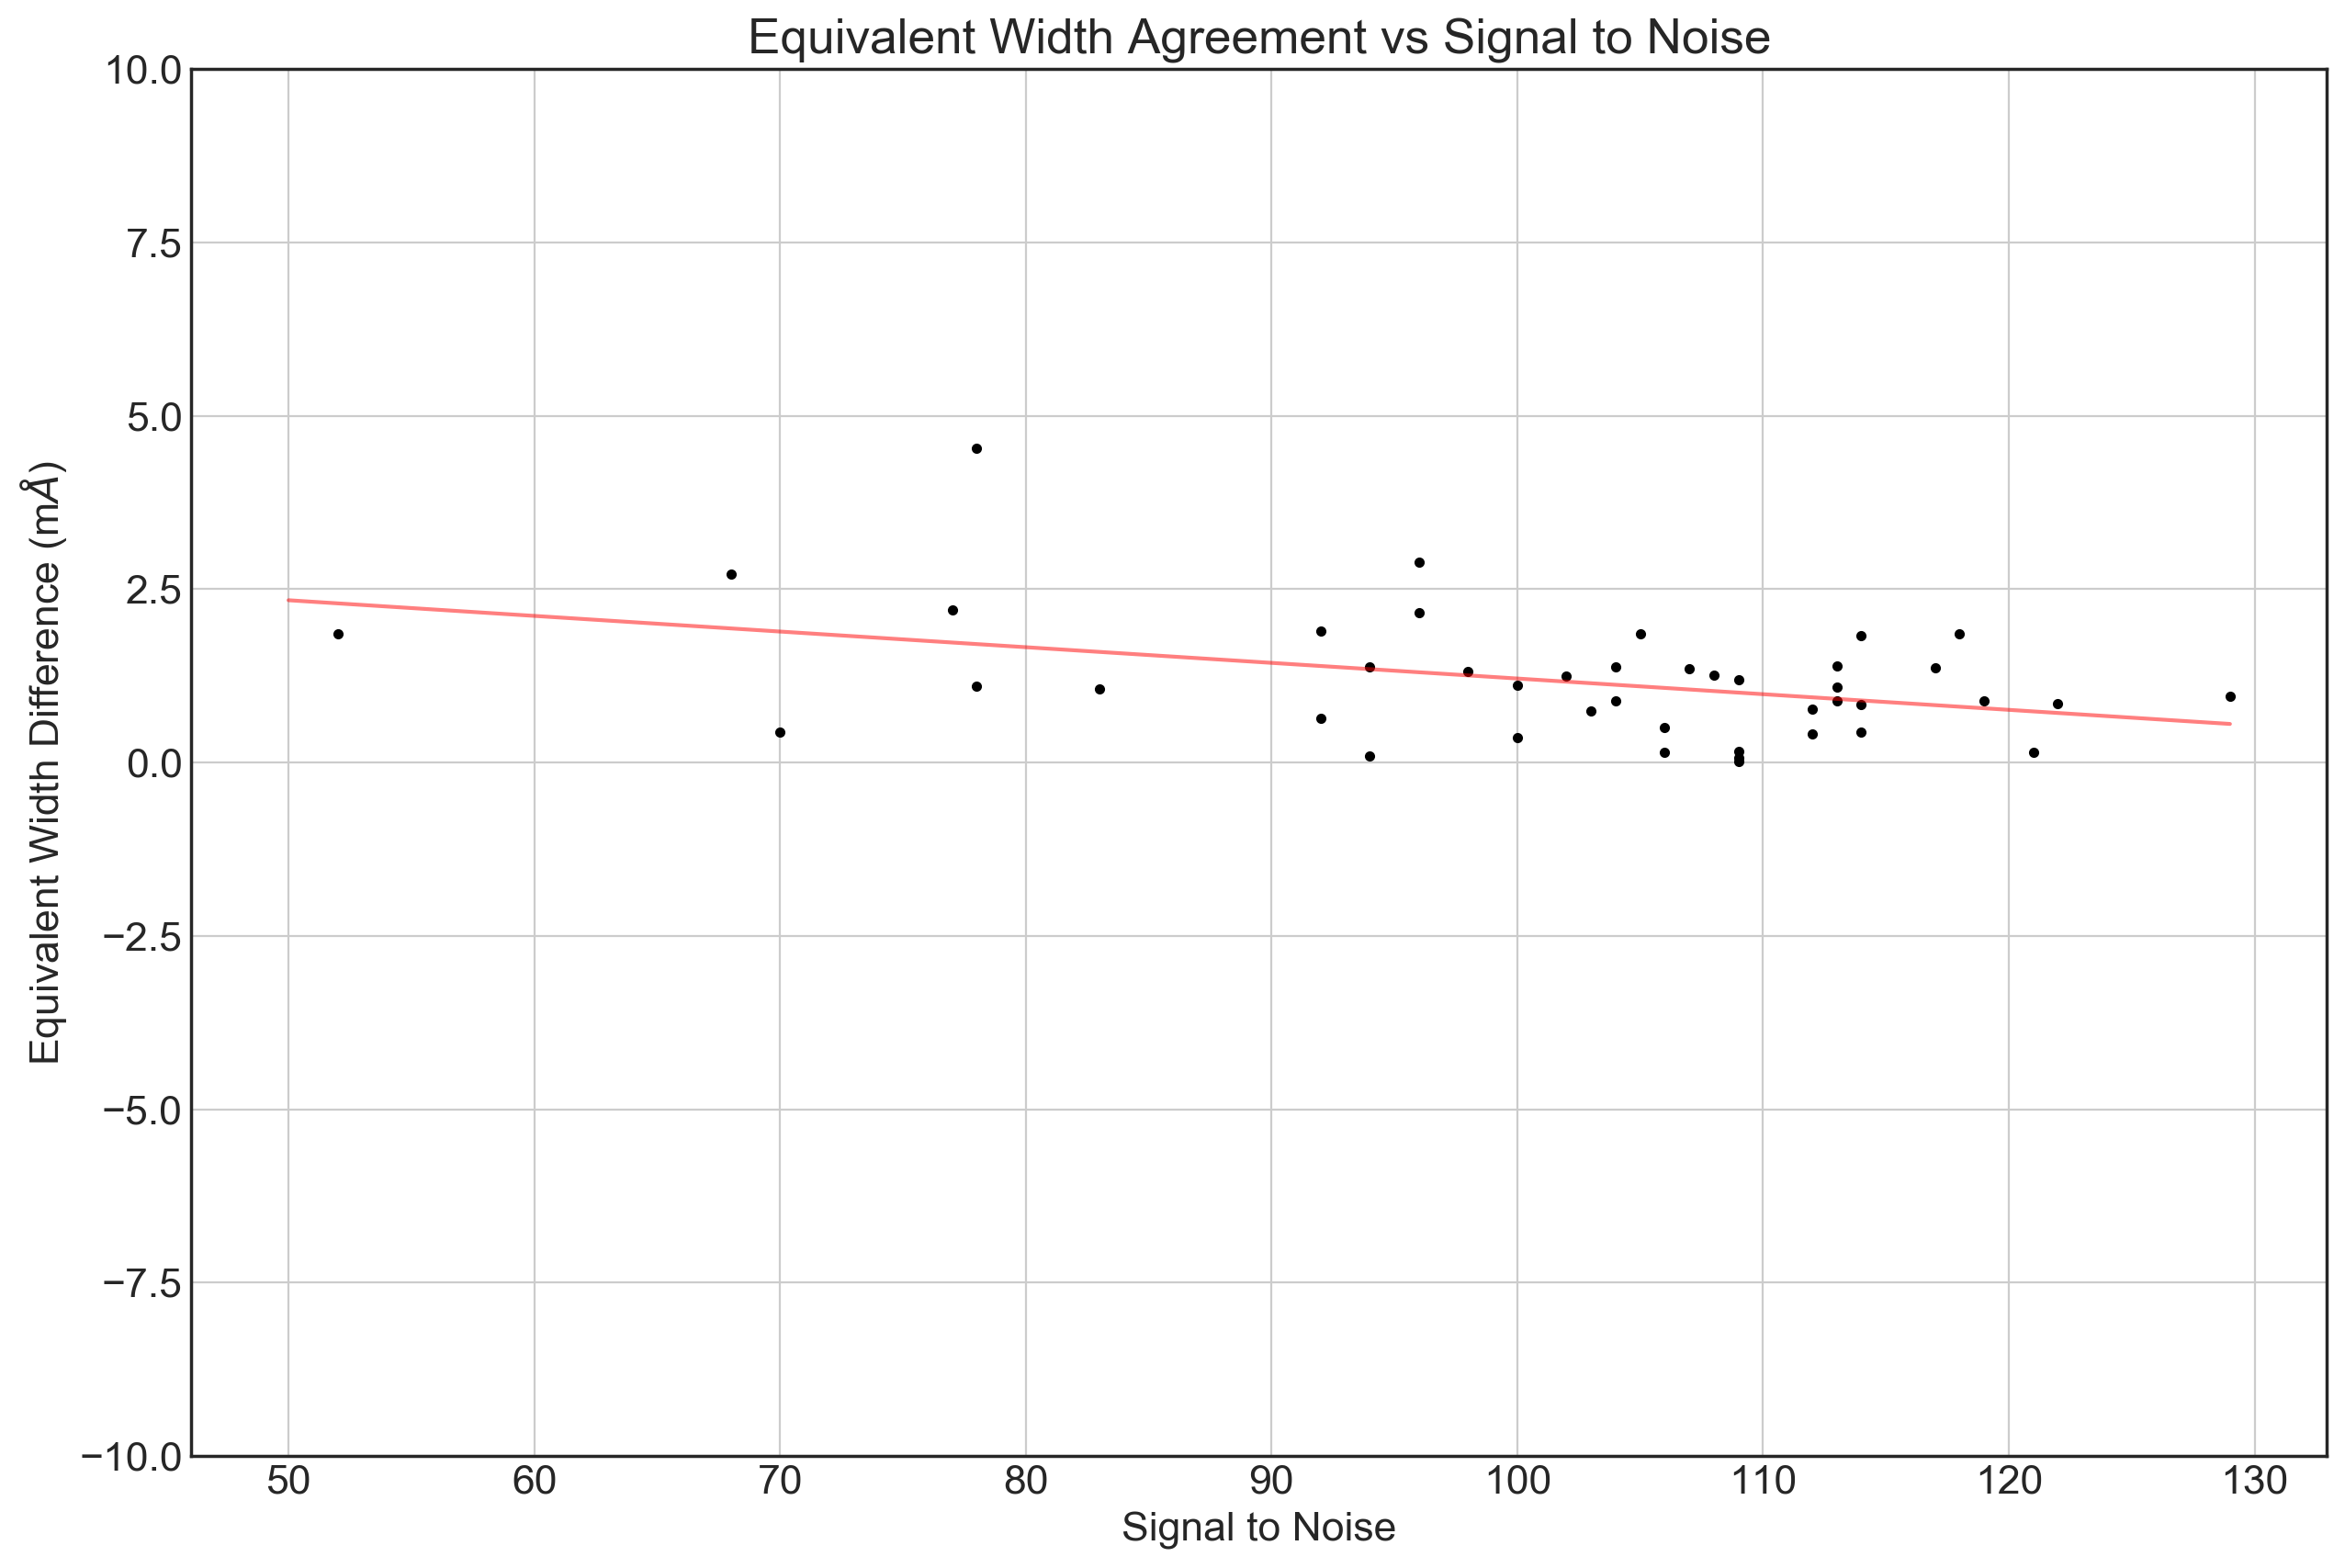

In [108]:
tame_outputs = glob.glob('data/ew_known/equiv_widths/*.ew')
byhand_outputs = ['data/ew_known/tame_inputs/'+output.split('/')[-1] for output in tame_outputs]
output_labels = [output.split('/')[-1].split('.')[0] for output in tame_outputs]


fig = plt.figure(figsize=(15,10))
fig.dpi = 200
plt.grid()
plt.xlabel(r"Signal to Noise")
plt.ylabel("Equivalent Width Difference (m$\AA$)")
plt.title("Equivalent Width Agreement vs Signal to Noise")
plt.ylim(-10,10)

pdiff_avg = []
snr_list = []
for i,byhand_output, tame_output,label in zip(color_idx,byhand_outputs, tame_outputs,output_labels):

    ew_hand = pd.read_csv(byhand_output,delim_whitespace=True,header = None)
    ew_tame = pd.read_csv(tame_output,skiprows=1,delim_whitespace=True,header=None)
    hand_df = ew_hand[[0,4]].sort_values(by=0, ascending=False) # Wavelength and Equivalent Width
    tame_df = ew_tame # Wavelength, Equivalent Width, and linecenter
    label_items = label.split("_")
    cluster, star = label_items[0:2]
    star = star[0:-3]
    
    df = snr_dict[cluster]
    idx = df.index[df['Star'] == int(star)].tolist()
    snr = float(df.loc[idx]['S/N'])
    pdiff = np.array(tame_df[1]) - np.array(hand_df[4])
    
       
    masked_pdiff = [val for val in pdiff if not np.isinf(val) and not (np.isnan(val))]
    pdiff_avg.append(abs(np.mean(masked_pdiff)))
    snr_list.append(snr)

#Attempt a linear fit
coeffs = np.polyfit(snr_list, pdiff_avg, 1)
print(list(coeffs))
p = np.poly1d(coeffs)

yhat = p(snr_list)
ybar = np.sum(pdiff_avg)/len(pdiff_avg)
ssreg = np.sum((yhat-ybar)**2)
sstot = np.sum((pdiff_avg - ybar)**2)
print("R-Squared: ",ssreg / sstot)

x = np.arange(50,130,1)
y = coeffs[0]*x + coeffs[1]
plt.plot(snr_list, pdiff_avg, '.', color='k', label=label)
plt.plot(x, y, '-', color='r', label=label, alpha = 0.5)

### Lowercut
For lowercut, the optimal values have been chosen per line from all of the observations with known EWs. However, signal-to-noise changes from observation to observation, so if the lowercut value correlates with snr this might introduce noise into the chosen lowercut value. In an attempt to characterize this, we'll look through all of the observations and compare the typical lowercut value chosen with the signal-to-noise of the observation.

[6.1536650538087973e-05, 0.97799851869964471]
R-Squared:  0.124567333148


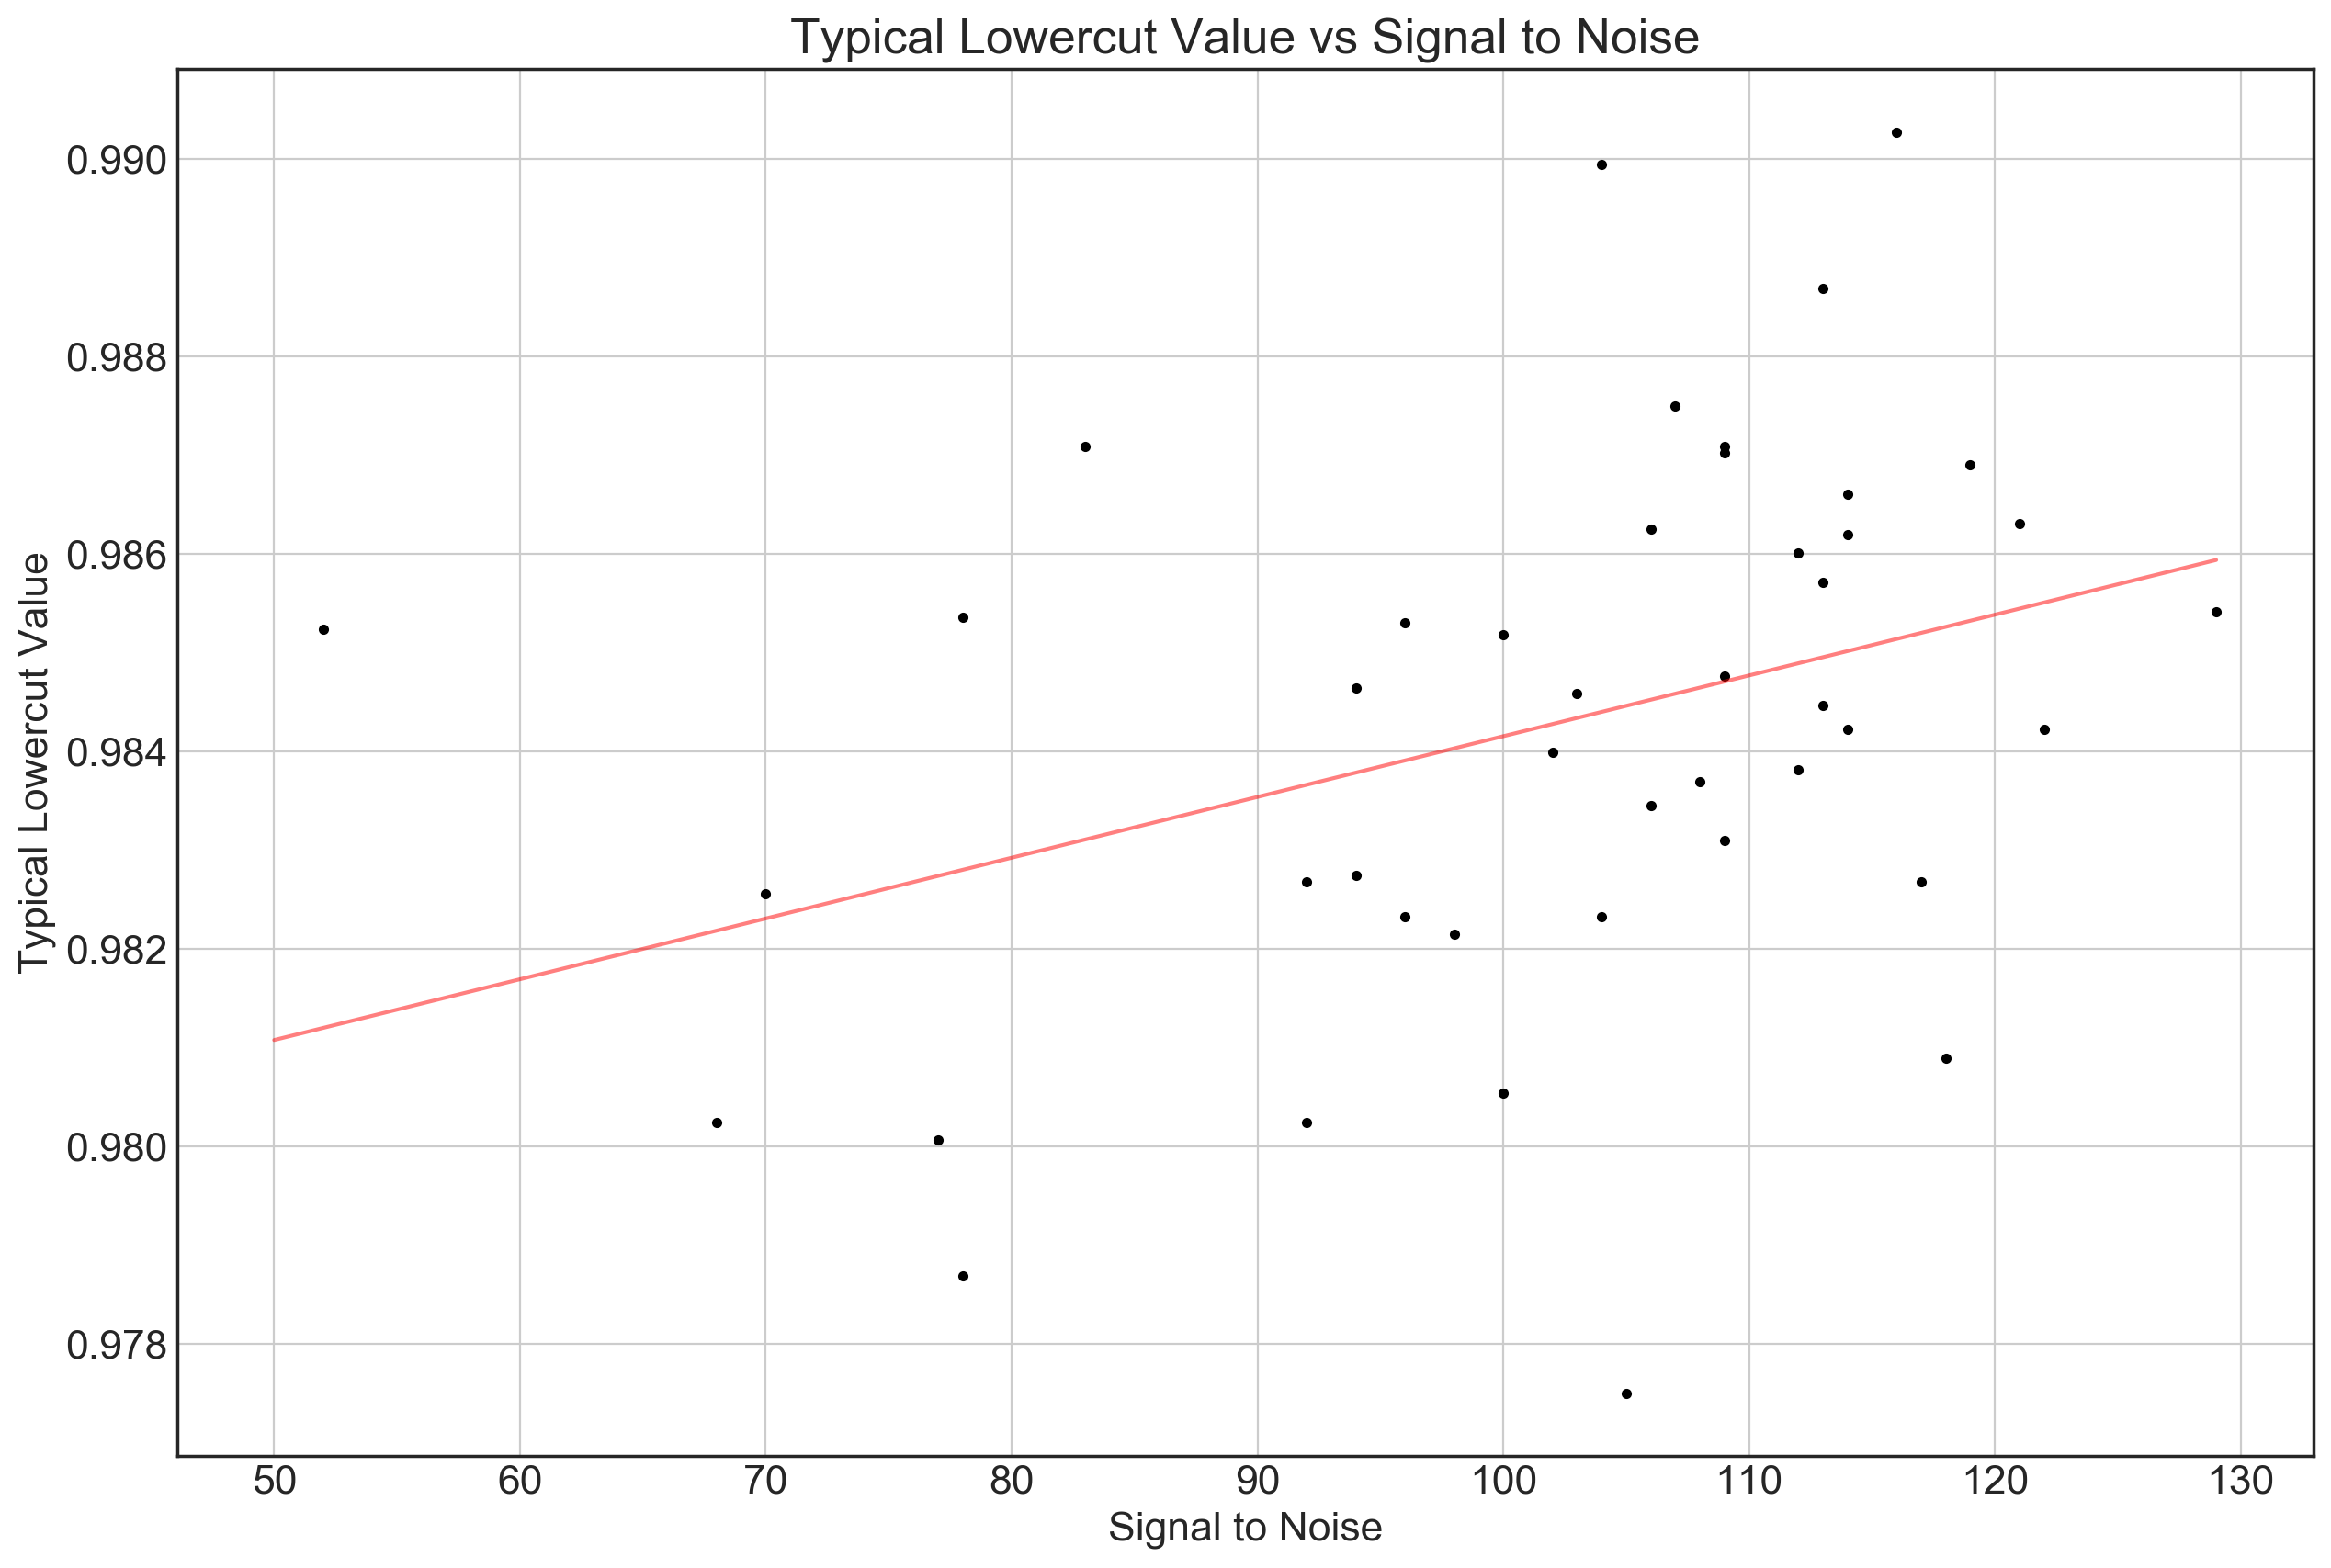

In [163]:
tame_outputs = glob.glob('data/ew_known/tame_outputs/*.json')
byhand_outputs = ['data/ew_known/tame_inputs/'+output.split('/')[-1].split(".")[0] + ".ew" for output in tame_outputs]
output_labels = [output.split('/')[-1].split('.')[0] for output in tame_outputs]


obs_snr = []
obs_lc = []
for byhand_output, tame_output in zip(byhand_outputs,tame_outputs):
    
    # Get S/N
    label_items = tame_output.split("/")[-1].split("_")
    cluster, star = label_items[0:2]
    star = star[0:-3]
    df = snr_dict[cluster]
    idx = df.index[df['Star'] == int(star)].tolist()
    snr = float(df.loc[idx]['S/N'])
    obs_snr.append(snr)
    
    # Get by-hand measurement dataframe
    ew_hand = pd.read_csv(byhand_output,delim_whitespace=True,header = None)
    hand_df = ew_hand[[0,4]].sort_values(by=0, ascending=False) # Wavelength and Equivalent Width
    
    
    # Read in json file of tame measurements
    with open(tame_output) as t:
        tame_data = json.load(t)
        
    line_lc = []    
    for line in tame_data.keys():
        idx = hand_df.index[hand_df[0] == float(line)].tolist()
        byhand_ew = float(hand_df.loc[idx][4])
        
        line_data = tame_data[line]
        lc = [run[0] for run in line_data]
        ew = [run[1] for run in line_data]
        min_idx = np.argmin(abs(np.array(ew)-byhand_ew))
        #print(lc[min_idx], ew[min_idx], byhand_ew)
        line_lc.append(lc[min_idx])
        
    obs_lc.append(np.mean(line_lc))
    
#Attempt a linear fit
coeffs = np.polyfit(obs_snr, obs_lc, 1)
print(list(coeffs))
p = np.poly1d(coeffs)

yhat = p(obs_snr)
ybar = np.sum(obs_lc)/len(obs_lc)
ssreg = np.sum((yhat-ybar)**2)
sstot = np.sum((obs_lc - ybar)**2)
print("R-Squared: ",ssreg / sstot)

x = np.arange(50,130,1)
y = coeffs[0]*x + coeffs[1]
    
fig = plt.figure(figsize=(15,10))
fig.dpi = 200
plt.grid()
plt.xlabel(r"Signal to Noise")
plt.ylabel("Typical Lowercut Value")
plt.title("Typical Lowercut Value vs Signal to Noise")

plt.plot(obs_snr, obs_lc, '.', color = 'k')
plt.plot(x, y, '-', color='r', label=label, alpha = 0.5)